In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import upsetplot

sys.path.append('./../src')

from scipy.stats import fisher_exact
from manuscript import inout, datasets, export

In [15]:
# Set plot defaults
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 20

## Data loading

In [17]:
# Load pubtator data
gene_info = pd.read_parquet("../data/resources/pubtator/gene_info.parquet")
pubtator_genes = pd.read_parquet("../data/resources/pubtator/pubtator_genes_in_title_or_abstract.parquet")

In [18]:
# Load pubmed IDs associated with each group
CCDG = datasets.pubmed_searchlist('CCDG')
CMG = datasets.pubmed_searchlist('CMG')

## Combine pubtator and instutional pubmed ID datasets

In [19]:
# Generate reference for pubmed ID and group
group_ref = pd.concat([CCDG, CMG], keys = ['Common Disease', 'Mendelian'])
group_ref['group'] = group_ref.index.get_level_values(0)

In [78]:
# Filter pubtator info for pubmed IDs from either group
data = pd.merge(left = group_ref, 
                right = pubtator_genes,
                right_on = 'pubmed_id',
                left_on = 'pubmed_id',
                how = 'inner')

In [79]:
# If publication is affiliated with both groups, relabel as 'Joint'
joint = group_ref.groupby('pubmed_id').count()
joint = joint.where(joint > 1).dropna().index

data['group'] = np.where(data['pubmed_id'].isin(joint), 'Joint', data['group'])
data = data.drop_duplicates()

In [80]:
# Merge gene info
data = pd.merge(left = data, 
                right = gene_info,
                right_on = 'gene_ncbi',
                left_on = 'gene_ncbi',
                how = 'left')

## Upset plot to show overlap in studied genes

In [24]:
# Upset plot takes input dictionary separately listing items associated with each category

# Create empty dict
upset_dict = dict()

# For each group in dataset (i.e. 'Common Disease', 'Joint', 'Mendelian')
for g in data['group'].unique():
    # Create a dictionary with the group name and associated genes 
    dnew = dict({g: data['gene_ncbi'][data['group'] == g].unique()})
    
    # If this is the first pass, save the dictionary of the first group
    if not bool(upset_dict):
        upset_dict = dnew
    # If this is not the first pass, append the new dictionary
    else: 
        upset_dict.update(dnew)

In [25]:
# Format for upset plot
upset_plot_data = upsetplot.from_contents(upset_dict)

<Figure size 4000x4000 with 0 Axes>

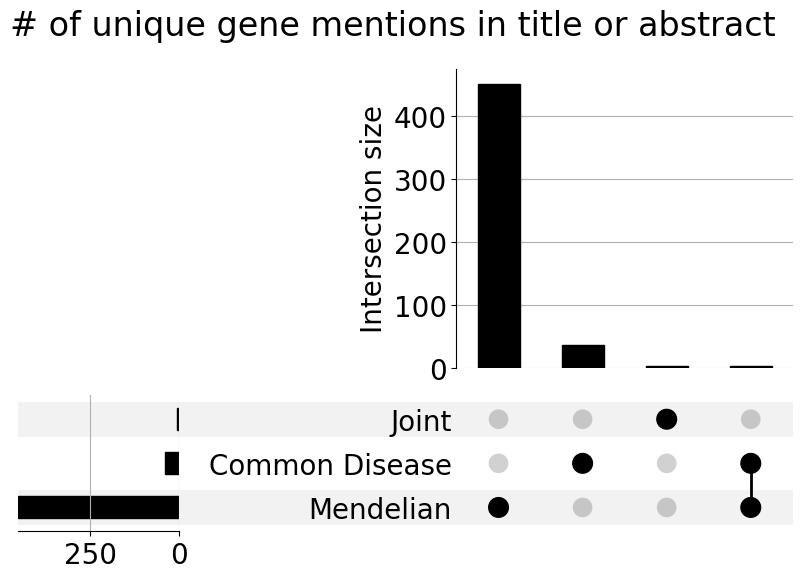

In [26]:
# Generate upset plot
fig = plt.figure(figsize=(40, 40))
upsetplot.UpSet(upset_plot_data, subset_size="count", element_size=None).plot()
plt.suptitle("# of unique gene mentions in title or abstract")

export.image(p='../figures/title_abstract_gene_mentions_by_CMG_CCDG.png')

In [86]:
len(data['gene_ncbi'].unique())

496

In [27]:
# Create contingency table for statistical analysis

In [72]:
# Recreate data table, keeping all genes in original pubtator data set
data = pd.merge(left = group_ref, 
                right = pubtator_genes,
                right_on = 'pubmed_id',
                left_on = 'pubmed_id',
                how = 'right')

In [73]:
# Function to cross-tabulate institutional designations
def group_crosstab(data):
    # Convert all NA values to 'Other' so they will by recognized by groupby('group')
    data['group'] = np.where(data['group'].isna(), 'Other', data['group'])

    # Determine if gene shows up at least once in a publication from any group
    data = data.groupby(['group', 'gene_ncbi']).count().reset_index()
    data['in_group'] = np.where(data['pubmed_id'] > 0, True, False)

    # Create separate columns for each group
    crosstab = data.pivot(
        index='gene_ncbi', 
        columns='group', 
        values='in_group'
        ).fillna(False)

    # Cross tabulate overlap from instutional groups
    crosstab = pd.crosstab(crosstab['Common Disease'], crosstab['Mendelian'])

    return(crosstab)

In [74]:
# Cross-tabulate data, counting joint collaboration studies towards both
crosstab = group_crosstab(data)
crosstab

Mendelian,False,True
Common Disease,,
False,18040,452
True,37,7


In [75]:
# Fisher exact test
fisher_exact(crosstab)

SignificanceResult(statistic=7.550825161444631, pvalue=9.458466719257708e-05)

In [69]:
# Rerun test removing CMG/CCDG joint collaboration studies as confounders
data['group'] = np.where(data['pubmed_id'].isin(joint), None, data['group'])
data = data.drop_duplicates()

In [70]:
crosstab = group_crosstab(data)
crosstab

Mendelian,False,True
Common Disease,,
False,18044,452
True,37,3


In [71]:
# Fisher exact test
fisher_exact(crosstab)

SignificanceResult(statistic=3.236785458024396, pvalue=0.0744893260322974)